In [33]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rarfile


In [1]:
import os

# Tentukan path ke file RAR di Google Drive
path = "/content/drive/MyDrive/Colab Notebooks/Proyek Dicoding/Dataset/"

# # Ekstrak file RAR
# with RarFile(path, 'r') as rf:
#     rf.extractall("/content/drive/MyDrive/Colab Notebooks/Proyek Dicoding/Dataset/")


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Proyek Dicoding/Dataset/",
    shuffle=True,
)

Found 2188 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names

print("Jenis Gerakan")
class_names

Jenis Gerakan


['paper', 'rock', 'scissors']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 2 0 2 2 0 0 1 1 0 2 1 0 0 1 2 1 1 1 1 1 0 1 1 0 2 1 2 1 1 0 2]


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3

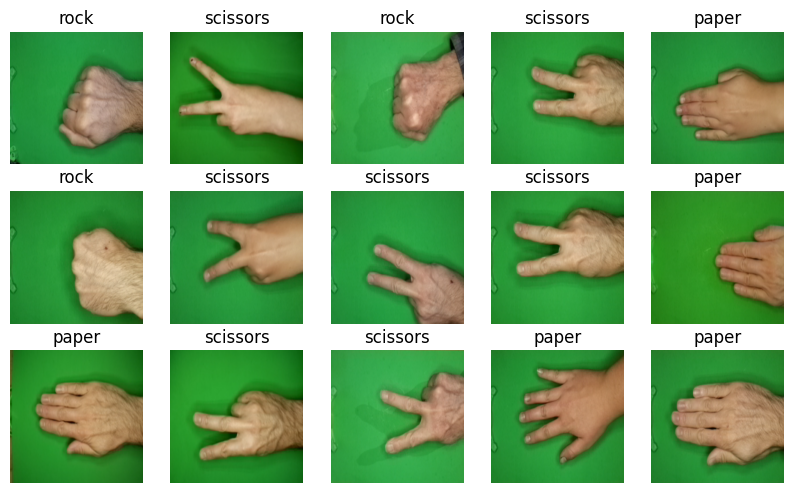

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range (15):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(
                    rescale=1./255)

In [ ]:
len(dataset)

69

In [ ]:
train_size = 0.6
len(dataset)*train_size

41.4

In [ ]:
train_ds = dataset.take(41)
len(train_ds)

41

In [ ]:
test_ds = dataset.skip(41)
len(test_ds)

28

In [ ]:
val_size = 0.4
len(dataset)*val_size

27.6

In [ ]:
val_ds = test_ds.take(27)
len(val_ds)

27

In [ ]:
test_ds = test_ds.skip(27)
len(test_ds)

1

In [ ]:
import math

def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.4, test_split=0.0, shuffle=True, shuffle_size=10000):
    assert math.isclose(train_split + val_split + test_split, 1, rel_tol=1e-9), "Split percentages must sum to 1."

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size).take(test_size)

    return train_ds, val_ds, test_ds


In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [ ]:
len(train_ds)

41

In [ ]:
len(val_ds)

27

In [ ]:
len(test_ds)

0

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
train_ds = train_ds.repeat()


In [72]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(300, 300, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(3136, activation='relu'),  # Sesuaikan jumlah unit dengan jumlah fitur yang dihasilkan oleh Flatten
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [73]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    epochs=25,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/25
41/41 [==============================] - 278s 7s/step - loss: 1.0986 - accuracy: 0.3361 - val_loss: 1.0843 - val_accuracy: 0.5225
Epoch 2/25
41/41 [==============================] - 233s 6s/step - loss: 0.8652 - accuracy: 0.5831 - val_loss: 0.7874 - val_accuracy: 0.5687
Epoch 3/25
41/41 [==============================] - 228s 6s/step - loss: 0.6571 - accuracy: 0.6852 - val_loss: 0.4941 - val_accuracy: 0.8009
Epoch 4/25
41/41 [==============================] - 230s 6s/step - loss: 0.4559 - accuracy: 0.8148 - val_loss: 0.3396 - val_accuracy: 0.8637
Epoch 5/25
41/41 [==============================] - 230s 6s/step - loss: 0.3232 - accuracy: 0.8788 - val_loss: 0.2748 - val_accuracy: 0.8922
Epoch 6/25
41/41 [==============================] - 227s 6s/step - loss: 0.2315 - accuracy: 0.9123 - val_loss: 0.2154 - val_accuracy: 0.9052
Epoch 7/25
41/41 [==============================] - 233s 6s/step - loss: 0.2310 - accuracy: 0.9154 - val_loss: 0.2155 - val_accuracy: 0.9171
Epoch 8/25
41

In [37]:
history = model.fit(
    train_ds,
    epochs=10,
    steps_per_epoch=25,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
25/25 [==============================] - 155s 6s/step - loss: 0.5360 - accuracy: 0.7912 - val_loss: 0.6314 - val_accuracy: 0.7595
Epoch 2/10
25/25 [==============================] - 151s 6s/step - loss: 0.5895 - accuracy: 0.7437 - val_loss: 0.4626 - val_accuracy: 0.8092
Epoch 3/10
25/25 [==============================] - 153s 6s/step - loss: 0.5204 - accuracy: 0.7875 - val_loss: 0.3767 - val_accuracy: 0.8697
Epoch 4/10
25/25 [==============================] - 151s 6s/step - loss: 0.3769 - accuracy: 0.8562 - val_loss: 0.3564 - val_accuracy: 0.8756
Epoch 5/10
25/25 [==============================] - 141s 6s/step - loss: 0.3326 - accuracy: 0.8587 - val_loss: 0.2563 - val_accuracy: 0.9123
Epoch 6/10
25/25 [==============================] - 153s 6s/step - loss: 0.3343 - accuracy: 0.8637 - val_loss: 0.3196 - val_accuracy: 0.8744
Epoch 7/10
25/25 [==============================] - 149s 6s/step - loss: 0.3149 - accuracy: 0.8737 - val_loss: 0.2176 - val_accuracy: 0.9265
Epoch 8/10
25

In [74]:
print("Classes:", class_names)


Classes: ['paper', 'rock', 'scissors']


In [63]:
classes


array([[0.7703269 , 0.22692415, 0.00274895]], dtype=float32)

In [66]:
print(class_names)


['paper', 'rock', 'scissors']


Saving batu.jpeg to batu (10).jpeg


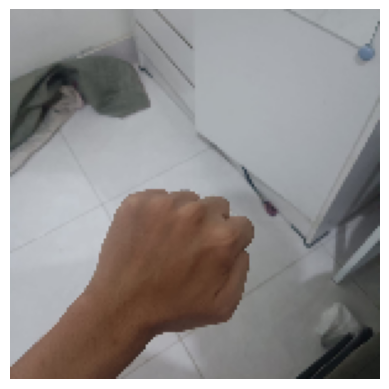

1/1 [==============================] - 0s 53ms/step
Predicted: Rock


In [92]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Unggah gambar
uploaded = files.upload()

# Loop melalui gambar yang diunggah
for fn in uploaded.keys():
    # Memuat gambar dan menyesuaikan ukurannya
    img = image.load_img(fn, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Konversi gambar menjadi larik Numpy
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Melakukan prediksi
    classes = model.predict(x)
    predicted_class = np.argmax(classes)

    # Menampilkan hasil prediksi
    if predicted_class == 0:
        print("Predicted: Scissors")
    elif predicted_class == 1:
        print("Predicted: Paper")
    elif predicted_class == 2:
        print("Predicted: Rock")


Saving gunting.jpeg to gunting (9).jpeg


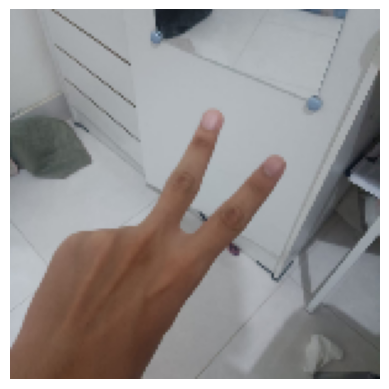

1/1 [==============================] - 0s 48ms/step
Predicted: Scissors


In [90]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Unggah gambar
uploaded = files.upload()

# Loop melalui gambar yang diunggah
for fn in uploaded.keys():
    # Memuat gambar dan menyesuaikan ukurannya
    img = image.load_img(fn, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Konversi gambar menjadi larik Numpy
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Melakukan prediksi
    classes = model.predict(x)
    predicted_class = np.argmax(classes)

    # Menampilkan hasil prediksi
    if predicted_class == 0:
        print("Predicted: Scissors")
    elif predicted_class == 1:
        print("Predicted: Paper")
    elif predicted_class == 2:
        print("Predicted: Rock")


Saving kertas.jpeg to kertas (12).jpeg


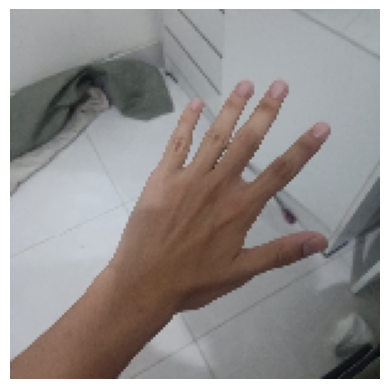

1/1 [==============================] - 0s 51ms/step
Predicted: Paper


In [91]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Unggah gambar
uploaded = files.upload()

# Loop melalui gambar yang diunggah
for fn in uploaded.keys():
    # Memuat gambar dan menyesuaikan ukurannya
    img = image.load_img(fn, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Konversi gambar menjadi larik Numpy
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Melakukan prediksi
    classes = model.predict(x)
    predicted_class = np.argmax(classes)

    # Menampilkan hasil prediksi
    if predicted_class == 0:
        print("Predicted: Scissors")
    elif predicted_class == 1:
        print("Predicted: Paper")
    elif predicted_class == 2:
        print("Predicted: Rock")
